In [8]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda import gpuarray, compiler
from osgeo import gdal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from datetime import datetime


In [9]:
def printGPU():
    # Print available CUDA devices
    print("%d device(s) found." % cuda.Device.count())           
    for ordinal in range(cuda.Device.count()):
        dev = cuda.Device(ordinal)
        print("Device #%d: %s" % (ordinal, dev.name()))
    print(cuda)

In [13]:
def cast_ray(point, direction, dsm, vegdem, vegdem2, scale, svf_type):
    azimuth, altitude = direction
    dx = np.cos(np.radians(altitude)) * np.sin(np.radians(azimuth))
    dy = np.cos(np.radians(altitude)) * np.cos(np.radians(azimuth))
    dz = np.sin(np.radians(altitude))

    x, y = point
    z = dsm[int(y), int(x)]  # Start at DSM height

    while 0 <= x < dsm.shape[1] and 0 <= y < dsm.shape[0]:
        dsm_height = dsm[int(y), int(x)]
        veg_height = vegdem[int(y), int(x)]
        canopy_bottom_height = vegdem2[int(y), int(x)]
        
        if svf_type == 'dsm':
            obstacle_height = dsm_height
        elif svf_type == 'veg':
            obstacle_height = dsm_height + veg_height
        elif svf_type == 'veg_blocking_buildings':
            obstacle_height = dsm_height + veg_height
            if z < canopy_bottom_height:
                return False
        else:
            raise ValueError("Invalid SVF type")
        
        if z < obstacle_height:
            return False
        
        x += dx * scale
        y += dy * scale
        z += dz * scale

    return True  # Ray is unobstructed

'\ndef cast_ray(point, direction, dsm, vegdem, vegdem2, scale, svf_type):\n    azimuth, altitude = direction\n    dx = np.cos(np.radians(altitude)) * np.sin(np.radians(azimuth))\n    dy = np.cos(np.radians(altitude)) * np.cos(np.radians(azimuth))\n    dz = np.sin(np.radians(altitude))\n\n    x, y = point\n    z = dsm[int(y), int(x)]  # Start at DSM height\n\n    while 0 <= x < dsm.shape[1] and 0 <= y < dsm.shape[0]:\n        dsm_height = dsm[int(y), int(x)]\n        veg_height = vegdem[int(y), int(x)]\n        canopy_bottom_height = vegdem2[int(y), int(x)]\n        \n        if svf_type == \'dsm\':\n            obstacle_height = dsm_height\n        elif svf_type == \'veg\':\n            obstacle_height = dsm_height + veg_height\n        elif svf_type == \'veg_blocking_buildings\':\n            obstacle_height = dsm_height + veg_height\n            if z < canopy_bottom_height:\n                return False\n        else:\n            raise ValueError("Invalid SVF type")\n        \n     

In [11]:
def svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, svf_type):
    """Calculate the Sky View Factor on the GPU, incorporating vegetation transparency using asynchronous memory transfers."""

    px = np.array(dsm).astype(np.float32)
    veg_px = np.array(vegdem).astype(np.float32)
    veg_px2 = np.array(vegdem2).astype(np.float32)
    height, width = px.shape
    
    # Initialize CUDA stream
    stream = cuda.Stream()

    # Allocate memory on the GPU
    d_px = gpuarray.to_gpu(px)
    d_veg_px = gpuarray.to_gpu(veg_px)
    d_veg_px2 = gpuarray.to_gpu(veg_px2)
    d_out = gpuarray.empty((height, width), np.float32)

    # Define the CUDA kernel for SVF calculation
    kernel_code = """
    #include <math.h>
    #define PI 3.141592654
    __global__ void svfcalculator(float * lattice_out, float * lattice, float * veg_lattice, float * veg_lattice2, float scale, float transparency_factor, int width, int height, int svf_type)
    {
        int ix = threadIdx.x + blockIdx.x * blockDim.x;
        int iy = threadIdx.y + blockIdx.y * blockDim.y;
        if (ix >= width || iy >= height) return;
        int index = ix + iy * width;
        float SVF_res = 0;
        float clr00 = lattice[index];

        for (int thetaN = 0; thetaN < 360; thetaN++) 
        {
            float theta = PI * float(thetaN) / 180;
            float betaMax = 0;

            for (float radius = 1; radius < 450; radius += 1)
            {   
                int x = ix + int(radius * cos(theta));
                int y = iy - int(radius * sin(theta));
                if (x < 0 || x >= width || y < 0 || y >= height) break;
                int index2 = x + y * width;
                
                float dsm_height = lattice[index2];
                float veg_height = veg_lattice[index2];
                float canopy_bottom_height = veg_lattice2[index2];

                if (svf_type == 0) {
                    // Only DSM consideration
                    if (dsm_height > clr00) {
                        float buildH = dsm_height - clr00;
                        float beta = atan(scale * buildH / radius); 
                        betaMax = fmax(betaMax, beta);
                    }
                }
                else if (svf_type == 1) {
                    // Only vegetation consideration
                    if (clr00 > canopy_bottom_height) {
                        if (veg_height > clr00) {
                            float vegH = veg_height - clr00;
                            float beta = atan(scale * vegH / radius); 
                            betaMax = fmax(betaMax, beta);
                        }
                    }
                }
                else if (svf_type == 2) {
                    // Vegetatie eerst, dan DSM
                    bool blocked_by_veg = false;
                    float betaMax_veg = 0;
                    float betaMax_dsm = 0;

                    // Check vegetatie blokkade
                    if (clr00 > canopy_bottom_height) {
                        if (clr00 < veg_height) {
                            blocked_by_veg = true;
                            float vegH = veg_height - clr00;
                            betaMax_veg = atan(scale * vegH / radius); 
                        }
                    }

                    // Check DSM blokkade alleen als niet geblokkeerd door vegetatie
                    if (blocked_by_veg && dsm_height > clr00) {
                        float buildH = dsm_height - clr00;
                        betaMax_dsm = atan(scale * buildH / radius); 
                    }

                    // Update betaMax only if both vegetatie and DSM block the ray
                    if (blocked_by_veg && dsm_height > clr00) {
                        betaMax = fmax(betaMax, betaMax_dsm);
                    }
                }
            }
            // Accumulate result
            SVF_res += pow(cos(betaMax), 2);
        }
        lattice_out[index] = SVF_res / 360.0;
    }
    """

    # Compile and execute the kernel
    mod = compiler.SourceModule(kernel_code)
    svf_kernel = mod.get_function("svfcalculator")

    # Thread and block dimensions for GPU execution
    block_size = (8, 8, 1)
    grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])))

    # Execute the kernel on the GPU
    svf_kernel(
        d_out, d_px, d_veg_px, d_veg_px2, np.float32(scale), np.float32(transparency_factor),
        np.int32(width), np.int32(height), np.int32(svf_type),
        block=block_size,
        grid=grid_size,
        stream=stream
    )
    
    # Synchronize the GPU
    cuda.Context.synchronize()

    return d_out.get()

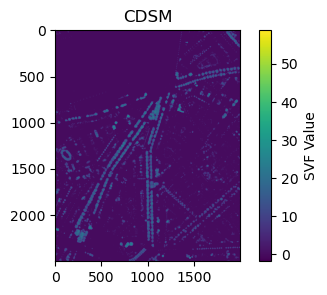

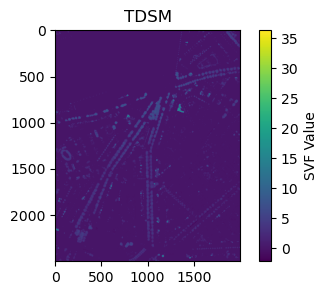

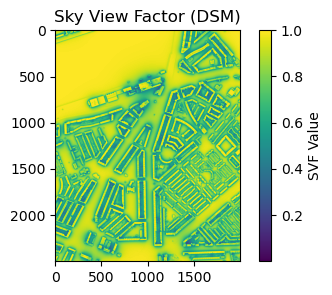

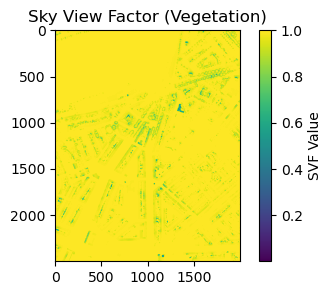

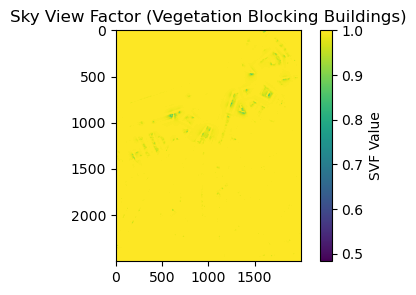

In [12]:
def main(dsm_path, vegdem_path, vegdem2_path, transparency_factor, output_dir):
    """Main function to load data, calculate SVF, and save the results."""

    #See if GPU is initialized right
    #printGPU()

    # Plot the SVFs
    def plot_svf(svf_data, title):
        plt.figure(figsize=(5, 3))
        plt.imshow(svf_data, cmap='viridis')
        plt.colorbar(label='SVF Value')
        plt.title(title)
        plt.show()
    
    # Load DSM and vegetation DEM using GDAL
    dsm_ds = gdal.Open(dsm_path)
    vegdem_ds = gdal.Open(vegdem_path)
    vegdem2_ds = gdal.Open(vegdem2_path)  # Load the canopy bottom DEM

    #Calculate scale from input DSM
    geotransform = dsm_ds.GetGeoTransform()
    scale = 1 / geotransform [1]
    
    dsm = dsm_ds.ReadAsArray().astype(np.float32)
    vegdem = vegdem_ds.ReadAsArray().astype(np.float32)
    vegdem2 = vegdem2_ds.ReadAsArray().astype(np.float32)  # Read the canopy bottom DEM


    # Add DSM height to vegetation heights
    vegdem = np.where(vegdem > 0, vegdem + dsm, vegdem)
    vegdem2 = np.where(vegdem2 > 0, vegdem2 + dsm, vegdem2)    

    # Apply Gaussian filter to vegdem
    vegdem = gaussian_filter(vegdem, sigma=0.5)
    vegdem2 = gaussian_filter(vegdem2, sigma=0.5)

    #Plot to see if CDSM/TDSM are loaded correctly
    plot_svf(vegdem, 'CDSM')
    plot_svf(vegdem2, 'TDSM')

    
    # Define svf_type mapping
    svf_type_mapping = {
        'dsm': 0,
        'veg': 1,
        'veg_blocking_buildings': 2
    }
    
    # Calculate SVFs on GPU
    svf_dsm = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, svf_type_mapping['dsm'])
    svf_veg = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, svf_type_mapping['veg'])
    svf_veg_blocking_buildings = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, svf_type_mapping['veg_blocking_buildings'])
    
    # Save the results as GeoTIFFs
    driver = gdal.GetDriverByName('GTiff')

    def save_svf(filename, svf_data):
        out_ds = driver.Create(filename, dsm.shape[1], dsm.shape[0], 1, gdal.GDT_Float32)
        out_ds.GetRasterBand(1).WriteArray(svf_data)
        out_ds.SetGeoTransform(dsm_ds.GetGeoTransform())
        out_ds.SetProjection(dsm_ds.GetProjection())
        out_ds.FlushCache()

    # Generate a timestamp string
    timestamp = datetime.now().strftime("%H%M%S")

    # Modify the filenames to include the timestamp
    save_svf(f"{output_dir}/svf_dsm_{timestamp}.tif", svf_dsm)
    save_svf(f"{output_dir}/svf_veg_{timestamp}.tif", svf_veg)
    save_svf(f"{output_dir}/svf_veg_blocking_buildings_{timestamp}.tif", svf_veg_blocking_buildings)


    # Plot each SVF
    plot_svf(svf_dsm, 'Sky View Factor (DSM)')
    plot_svf(svf_veg, 'Sky View Factor (Vegetation)')
    plot_svf(svf_veg_blocking_buildings, 'Sky View Factor (Vegetation Blocking Buildings)')


if __name__ == "__main__":
    # Define file paths and parameters
    dsm_path = "C:/Users/Max/Documents/Werk/test_gpu/input/dsm_buildings_ground_37HN1_14.tif"       # DSM raster file path
    vegdem_path = "C:/Users/Max/Documents/Werk/test_gpu/input/cdsm_groundlvl_37HN1_14.tif"          # CDSM raster file path
    vegdem2_path = "C:/Users/Max/Documents/Werk/test_gpu/input/TDSM.tif"                            # TDSM raster file path
    transparency_factor = 0.97                                                                      # Transparency/opacity factor for vegetation impact
    output_dir = "C:/Users/Max/Documents/Werk/test_gpu/output/bigger_terr"                          # Output directory

    gdal.UseExceptions()
    main(dsm_path, vegdem_path, vegdem2_path, transparency_factor, output_dir)